# SQL Patterns: HAVING, Subqueries, and Surrogate Keys

This notebook demonstrates practical SQL patterns used in analytics and operations:
- Handling repeated identifiers (DO numbers) and line-level aggregation
- `GROUP BY` + `HAVING` for cohort/exception filtering
- Derived attributes and enrichment for more realistic KPI cuts
- Exception detection and lane risk segmentation


In [1]:
# Core setup
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.width", 140)
pd.set_option("display.max_columns", 80)
np.random.seed(42)

def q(conn, sql, params=None):
    """Run a SQL query and return a DataFrame."""
    return pd.read_sql_query(sql, conn, params=params or {})

In [2]:
# Utility helpers for richer outputs
def show_schema(conn):
    tables = q(conn, "SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%' ORDER BY name;")
    print("Tables:", ", ".join(tables["name"].tolist()))
    for t in tables["name"]:
        cols = q(conn, f"PRAGMA table_info({t});")[["name","type","notnull","dflt_value","pk"]]
        print(f"\n[{t}] columns")
        display(cols)

def row_counts(conn):
    tables = q(conn, "SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%' ORDER BY name;")
    out=[]
    for t in tables["name"]:
        n = q(conn, f"SELECT COUNT(*) AS n FROM {t};")["n"].iloc[0]
        out.append((t, int(n)))
    df = pd.DataFrame(out, columns=["table","rows"]).sort_values("rows", ascending=False)
    display(df)

def plot_hist(series, title, bins=25):
    plt.figure()
    plt.hist(series, bins=bins)
    plt.title(title)
    plt.xlabel(series.name if series.name else "value")
    plt.ylabel("count")
    plt.show()

In [3]:
# Database init
conn = sqlite3.connect(":memory:")
conn.execute("PRAGMA foreign_keys = ON;")
print("SQLite version:", q(conn, "select sqlite_version() as version")["version"].iloc[0])

SQLite version: 3.40.1


## Schema
Line-level delivery table with a composite uniqueness constraint per DO + line.

In [4]:
conn.executescript("""
CREATE TABLE deliveries(
    delivery_id INTEGER PRIMARY KEY,
    do_number TEXT NOT NULL,
    line_no INTEGER NOT NULL,
    ship_type TEXT NOT NULL,
    ship_to_country TEXT NOT NULL,
    gross_weight REAL NOT NULL CHECK (gross_weight >= 0),
    dg_flag TEXT NOT NULL CHECK (dg_flag IN ('Y','N')),
    delivery_date TEXT NOT NULL,
    qty INTEGER NOT NULL CHECK (qty>0),
    UNIQUE(do_number, line_no)
);
""")
print("Schema created.")

Schema created.


## Data Generation
Generate delivery lines where DO numbers repeat across multiple line items (realistic for order line modeling).

In [5]:
n_do = 120
rows = []
do_numbers = [f"DO-{700000+i}" for i in range(n_do)]

for do in do_numbers:
    lines = np.random.randint(1, 10)  # repeated DO with multiple lines
    for ln in range(1, lines+1):
        rows.append((
            do, ln,
            np.random.choice(["Air","Sea","Road"], p=[0.30,0.50,0.20]),
            np.random.choice(["PA","HN","CR","GT","SV","MX","CO"]),
            float(np.round(np.random.uniform(0.1, 65.0), 2)),
            np.random.choice(["Y","N"], p=[0.09,0.91]),
            (pd.Timestamp("2025-01-01")+pd.to_timedelta(np.random.randint(0,45), unit="D")).date().isoformat(),
            int(np.random.randint(1,6))
        ))

conn.executemany("""
INSERT INTO deliveries(do_number,line_no,ship_type,ship_to_country,gross_weight,dg_flag,delivery_date,qty)
VALUES (?,?,?,?,?,?,?,?)
""", rows)

print("Inserted delivery lines:", len(rows))
show_schema(conn)
row_counts(conn)

Inserted delivery lines: 610
Tables: deliveries

[deliveries] columns


,name,type,notnull,dflt_value,pk
0,delivery_id,INTEGER,0,None,1
1,do_number,TEXT,1,None,0
2,line_no,INTEGER,1,None,0
3,ship_type,TEXT,1,None,0
4,ship_to_country,TEXT,1,None,0
5,gross_weight,REAL,1,None,0
6,dg_flag,TEXT,1,None,0
7,delivery_date,TEXT,1,None,0
8,qty,INTEGER,1,None,0


,table,rows
0,deliveries,610


## DO-level Aggregation (GROUP BY)
Aggregate repeated DO numbers into operational metrics.

Top DOs by total weight:


,do_number,line_count,total_qty,total_weight,avg_line_weight,dg_rate_pct
0,DO-700012,9,24,362.65,40.29,11.11
1,DO-700107,9,23,357.08,39.68,11.11
2,DO-700010,8,29,315.00,39.38,12.50
3,DO-700002,9,23,313.83,34.87,0.00
4,DO-700039,9,30,312.43,34.71,0.00
5,DO-700025,8,22,308.93,38.62,0.00
6,DO-700102,9,21,308.45,34.27,11.11
7,DO-700067,7,23,299.50,42.79,14.29
8,DO-700072,9,33,299.14,33.24,0.00
9,DO-700118,8,21,292.22,36.53,0.00


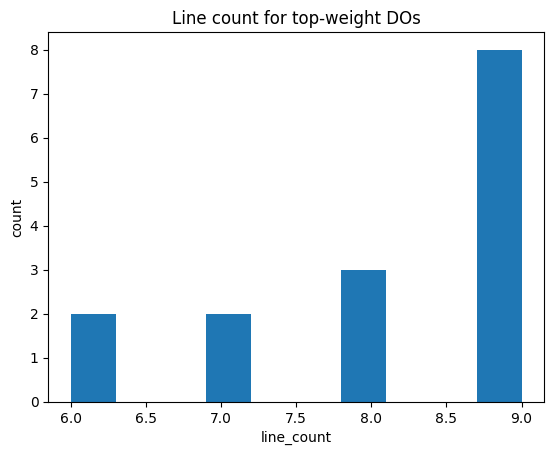

In [6]:
do_agg = q(conn, """
SELECT
    do_number,
    COUNT(*) AS line_count,
    SUM(qty) AS total_qty,
    ROUND(SUM(gross_weight),2) AS total_weight,
    ROUND(AVG(gross_weight),2) AS avg_line_weight,
    ROUND(100.0 * AVG(CASE WHEN dg_flag='Y' THEN 1 ELSE 0 END), 2) AS dg_rate_pct
FROM deliveries
GROUP BY do_number
ORDER BY total_weight DESC
LIMIT 15;
""")
print("Top DOs by total weight:")
display(do_agg)

plot_hist(do_agg["line_count"].rename("line_count"), "Line count for top-weight DOs", bins=10)

## HAVING for Cohort Filtering
Find dense DOs (many lines) which are typically operationally complex.

In [7]:
heavy = q(conn, """
SELECT do_number,
       COUNT(*) AS line_count,
       SUM(qty) AS total_qty,
       ROUND(SUM(gross_weight),2) AS total_weight
FROM deliveries
GROUP BY do_number
HAVING COUNT(*) >= 7
ORDER BY line_count DESC, total_weight DESC
LIMIT 20;
""")
print("DOs with 7+ lines:")
display(heavy)

DOs with 7+ lines:


,do_number,line_count,total_qty,total_weight
0,DO-700012,9,24,362.65
1,DO-700107,9,23,357.08
2,DO-700002,9,23,313.83
3,DO-700039,9,30,312.43
4,DO-700102,9,21,308.45
5,DO-700072,9,33,299.14
6,DO-700048,9,27,287.90
7,DO-700111,9,20,286.07
8,DO-700100,9,30,266.98
9,DO-700076,9,29,259.73


## Enrichment
Add carrier and service level for more realistic KPI cuts.

In [8]:
conn.executescript("""
ALTER TABLE deliveries ADD COLUMN carrier TEXT DEFAULT 'Local';
ALTER TABLE deliveries ADD COLUMN service_level TEXT DEFAULT 'Standard';
""")

carriers = ["DHL","UPS","FedEx","LocalCourier"]
levels = ["Standard","Express"]

ids = q(conn, "SELECT delivery_id FROM deliveries;")["delivery_id"].tolist()
for did in ids:
    np.random.seed(int(did))
    conn.execute(
        "UPDATE deliveries SET carrier=?, service_level=? WHERE delivery_id=?;",
        (np.random.choice(carriers), np.random.choice(levels, p=[0.78,0.22]), int(did))
    )

print("Enrichment applied to", len(ids), "rows.")

Enrichment applied to 610 rows.


## Carrier Performance
Compare volume, weight, and DG exposure across carriers.

,carrier,lines,total_weight,avg_line_weight,dg_rate_pct,avg_qty_per_line
0,UPS,165,5604.67,33.97,7.88,2.98
1,LocalCourier,147,4846.38,32.97,9.52,2.97
2,DHL,148,4830.41,32.64,12.16,3.12
3,FedEx,150,4643.97,30.96,14.67,2.80


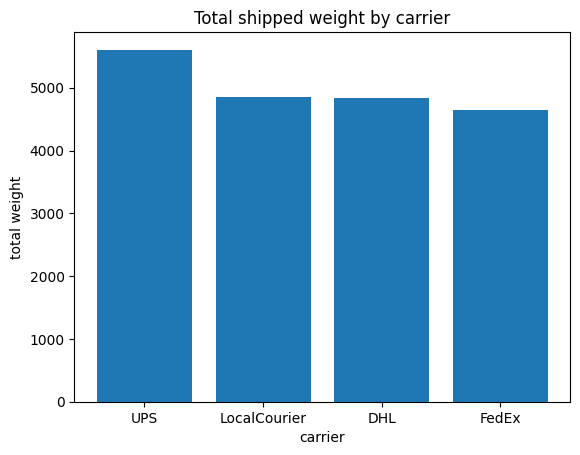

In [9]:
carrier_perf = q(conn, """
SELECT carrier,
       COUNT(*) AS lines,
       ROUND(SUM(gross_weight), 2) AS total_weight,
       ROUND(AVG(gross_weight), 2) AS avg_line_weight,
       ROUND(100.0 * AVG(CASE WHEN dg_flag='Y' THEN 1 ELSE 0 END), 2) AS dg_rate_pct,
       ROUND(AVG(qty), 2) AS avg_qty_per_line
FROM deliveries
GROUP BY carrier
ORDER BY total_weight DESC;
""")
display(carrier_perf)

plt.figure()
plt.bar(carrier_perf["carrier"], carrier_perf["total_weight"])
plt.title("Total shipped weight by carrier")
plt.xlabel("carrier")
plt.ylabel("total weight")
plt.show()

## Exception Detection
Flag unusually heavy lines relative to their lane baseline (country + service level).

In [10]:
exceptions = q(conn, """
WITH stats AS (
    SELECT ship_to_country, service_level,
           AVG(gross_weight) AS avg_w,
           (AVG(gross_weight) * 2.5) AS threshold
    FROM deliveries
    GROUP BY ship_to_country, service_level
)
SELECT d.delivery_id, d.do_number, d.ship_to_country, d.service_level,
       d.carrier, d.gross_weight, ROUND(s.threshold, 2) AS threshold
FROM deliveries d
JOIN stats s
  ON s.ship_to_country = d.ship_to_country
 AND s.service_level = d.service_level
WHERE d.gross_weight > s.threshold
ORDER BY d.gross_weight DESC
LIMIT 25;
""")
display(exceptions)
print("Flagged exceptions:", len(exceptions))

,delivery_id,do_number,ship_to_country,service_level,carrier,gross_weight,threshold


Flagged exceptions: 0


## Delivery-Level Risk Summary
Consolidate operational risk by lane using DG exposure and weight distribution.

Delivery risk summary by lane:


,ship_to_country,service_level,lines,total_weight,avg_weight,dg_rate_pct,risk_level
0,PA,Standard,68,1911.31,28.11,13.24,Medium
1,PA,Express,25,742.51,29.70,4.00,Medium
2,SV,Express,17,501.80,29.52,0.00,Medium
3,CR,Express,18,494.31,27.46,11.11,Medium
4,MX,Standard,70,2679.39,38.28,7.14,High
5,HN,Standard,76,2546.38,33.51,10.53,High
6,GT,Standard,78,2472.27,31.70,12.82,High
7,SV,Standard,73,2229.05,30.53,12.33,High
8,CO,Standard,64,2081.48,32.52,10.94,High
9,CR,Standard,55,1915.36,34.82,14.55,High


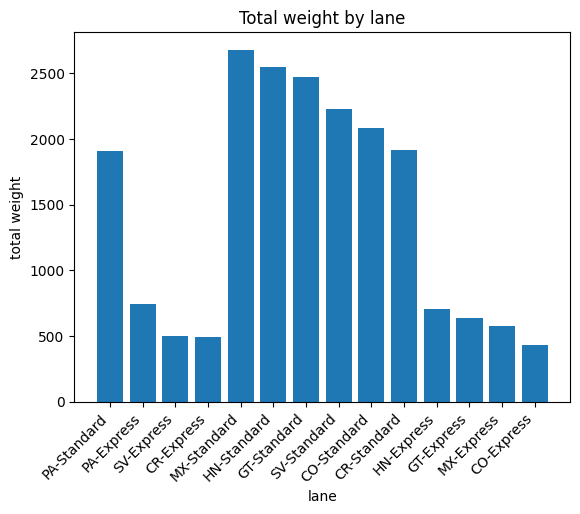

In [11]:
risk_summary = q(conn, """
WITH base AS (
    SELECT
        ship_to_country,
        service_level,
        COUNT(*) AS lines,
        SUM(gross_weight) AS total_weight,
        AVG(gross_weight) AS avg_weight,
        AVG(CASE WHEN dg_flag='Y' THEN 1 ELSE 0 END) AS dg_rate
    FROM deliveries
    GROUP BY ship_to_country, service_level
)
SELECT
    ship_to_country,
    service_level,
    lines,
    ROUND(total_weight,2) AS total_weight,
    ROUND(avg_weight,2) AS avg_weight,
    ROUND(100*dg_rate,2) AS dg_rate_pct,
    CASE
        WHEN dg_rate > 0.15 OR avg_weight > 30 THEN 'High'
        WHEN dg_rate > 0.07 OR avg_weight > 22 THEN 'Medium'
        ELSE 'Low'
    END AS risk_level
FROM base
ORDER BY risk_level DESC, total_weight DESC;
""")

print("Delivery risk summary by lane:")
display(risk_summary)

lane = risk_summary.copy()
lane["lane"] = lane["ship_to_country"].astype(str) + "-" + lane["service_level"].astype(str)

plt.figure()
plt.bar(lane["lane"], lane["total_weight"])
plt.title("Total weight by lane")
plt.xlabel("lane")
plt.ylabel("total weight")
plt.xticks(rotation=45, ha="right")
plt.show()